# 2. VIENNA dataset exploratory data analysis

- quantify and visualize how HVPG correlates with variables we would like to use to predict it with

<sub>original notebook name: `VICIS_02_exploratory_analysis.ipynb`</sub>

In [1]:
from math import ceil                               # round numbers up, used in visualizations
import numpy as np                                  # numerical computing tools
import pandas as pd                                 # data science library

import seaborn as sns                               # visualizations
import matplotlib.pyplot as plt                     # visualizations
from matplotlib.lines import Line2D

from IPython.display import set_matplotlib_formats

from sklearn.decomposition import PCA                # PCA


sns.set_theme(font_scale = 1.45, style="darkgrid")   # nice theme for seaborn and set font size
set_matplotlib_formats('retina')                     # high resolution

## Load data (missing data imputed with kNN)

In [ ]:
data = pd.read_pickle("../preprocessed/VICIS_CeMM_preprocessed_v3_kNN_imputed.pickle")

# try this with median-replaced data
#data = pd.read_pickle("../preprocessed/VICIS_CeMM_preprocessed_v3_median_replaced.pickle")

data.head()

## Spearman correlation of HVPG with other variables

###  25 variables with highest positive correlation

In [3]:
# calculate correlations
correlations = data.corr(method="spearman")["HVPG"]

# list them
correlations.sort_values(ascending=False)[:25]

HVPG                1.000000
ELF                 0.650588
BL_STIFFNESS        0.540880
BA                  0.507296
INR                 0.488509
NH3                 0.446115
aPTT                0.445024
BILI                0.430939
MELD-UNOS           0.427979
GGT                 0.339975
PLGF                0.306935
ASAT                0.303288
vWF_Ag              0.298136
SFLT1               0.293165
PFA100_EPI          0.265090
AP                  0.247874
ALD                 0.247051
Ph                  0.246167
D-Dim               0.246016
ERY-DISTRIBUTION    0.229358
PCT                 0.221740
CRP                 0.194551
IL6                 0.169642
AGE                 0.147250
GLUC                0.144748
Name: HVPG, dtype: float64

###  25 variables with highest negative correlation

In [4]:
correlations.sort_values(ascending=True)[:25]

Pro_C_Act      -0.521592
AT-III_Act     -0.464140
TPZ%           -0.461570
VIT_A          -0.458159
ALB            -0.393398
PLT            -0.392532
CHE            -0.354537
ERY            -0.349208
Mg             -0.304417
HKT            -0.292897
KREA           -0.277042
HB             -0.250382
Ca             -0.219594
VIRAL          -0.218065
FGEN           -0.214294
BUN            -0.211329
LDL            -0.208025
COPEPTIN-ADH   -0.184708
WBC            -0.178867
SEROTONIN      -0.177034
PT_F1,2        -0.170908
CHOL           -0.167148
LBP            -0.162445
SFLT1/PLGF_Q   -0.147763
BA-TEST        -0.128483
Name: HVPG, dtype: float64

### Save as excel

In [5]:
# convert to data frame
correlations_DF = pd.DataFrame(correlations)

# rename columns
correlations_DF.index.name = "Variable"
correlations_DF.columns = ["Correlation with HVPG"]

# save
correlations_DF.to_excel("../exploratory_analysis/HVPG_spearman_correlations.xlsx")

## Histogram of dependent variable HVPG

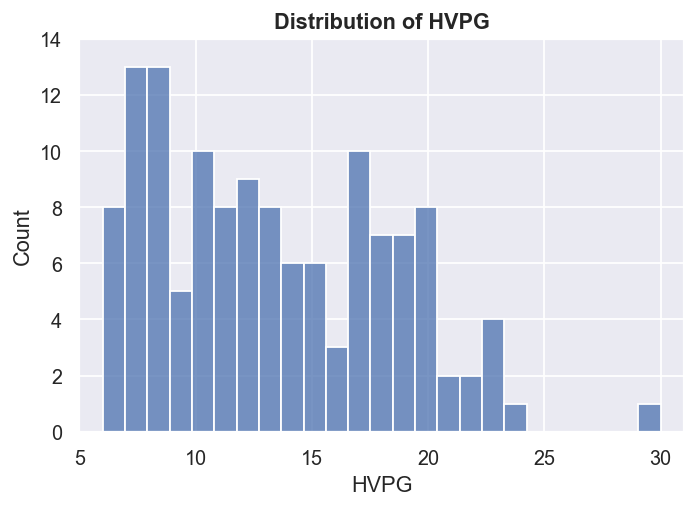

In [6]:
sns.set_context(context="notebook", font_scale=1)
plt.figure(figsize=(6,4), dpi = 65)
sns.histplot(data, x="HVPG", bins=25)
plt.xlim(5, 31)
plt.xticks(range(5,31,5))
plt.yticks(range(0,15,2))
plt.title("Distribution of HVPG", fontweight="bold")
plt.show()

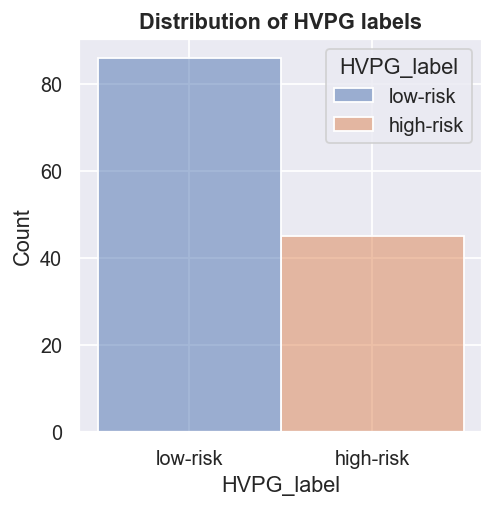

In [7]:
sns.set_context(context="notebook", font_scale=1)
plt.figure(figsize=(4,4), dpi= 65)
sns.histplot(data, x="HVPG_label", hue="HVPG_label")
plt.title("Distribution of HVPG labels", fontweight="bold")
plt.show()

## Scatterplots of HVPG against selected variables, highlight if value was imputed

#### Get information which values were imputed

In [8]:
# create a dataframe which says whether a value is imputated or not
imputed = pd.read_pickle("../preprocessed/VICIS_CeMM_preprocessed_v3_missing_kept.pickle").isna()

# rename columns : add _inputed suffix
imputed.columns = [x + "_imputed" for x in imputed.columns]

# new dataframe with everything merged
merged = pd.concat([data, imputed], axis=1)

#### Select variables based on literature and correlation with HVPG

In [9]:
# selected arbitrarily based on literature
selected = ["ELF", "vWF_Ag", "BL_STIFFNESS", "MELD-UNOS"]

# positively correlated, not in the previous selection
positive_corr = list(correlations.sort_values(ascending=False)[1:5].index)

# top 5 negatively correlated
negative_corr = list(correlations.sort_values(ascending=True)[:4].index)

#### Visualization function
- input: merged data, correlations with HVPG and selected variables

In [10]:
def show_HVPG_scatter(data, correlations, selected, save=False):
    # create the plot, 4 columns and flexible number of rows, based on the number of selected parameters
    nrow = ceil(len(selected)/4)
    fig, axes = plt.subplots(ncols=4, nrows=nrow, figsize = (20,nrow*5), dpi = 80)
    fig.subplots_adjust(hspace =.3)

    plt.rcParams.update({'legend.labelspacing':0.25})
   
    # scatter plot of HVPG against selected variables, show imputed values in different color
    for i in range(len(selected)):
        ax = axes.flat[i]
        imputed = data[data[selected[i]+"_imputed"]].shape[0]
        plt.legend([],[], frameon=False)
        sns.scatterplot(data=data, x=selected[i], y="HVPG", hue=selected[i]+"_imputed", ax=ax)
        
        
        if imputed:
            custom = [Line2D([], [], marker='.', color=sns.color_palette(as_cmap=True)[1], linestyle='None')]
            ax.legend(custom, [f'imputed (n = {imputed})'],
                      loc='upper left', markerscale=1.33, handlelength = 0.5)
        else:
            ax.get_legend().remove()
        ax.get_xaxis().set_label_text("{} (rs = {:.3f})".format(selected[i], correlations[selected[i]]))
        # show y axis label only for first subplot on each row
        if i%4:
            ax.get_yaxis().set_label_text("")
    
    if save:
        plt.savefig(save, bbox_inches = 'tight')
    
    plt.show()

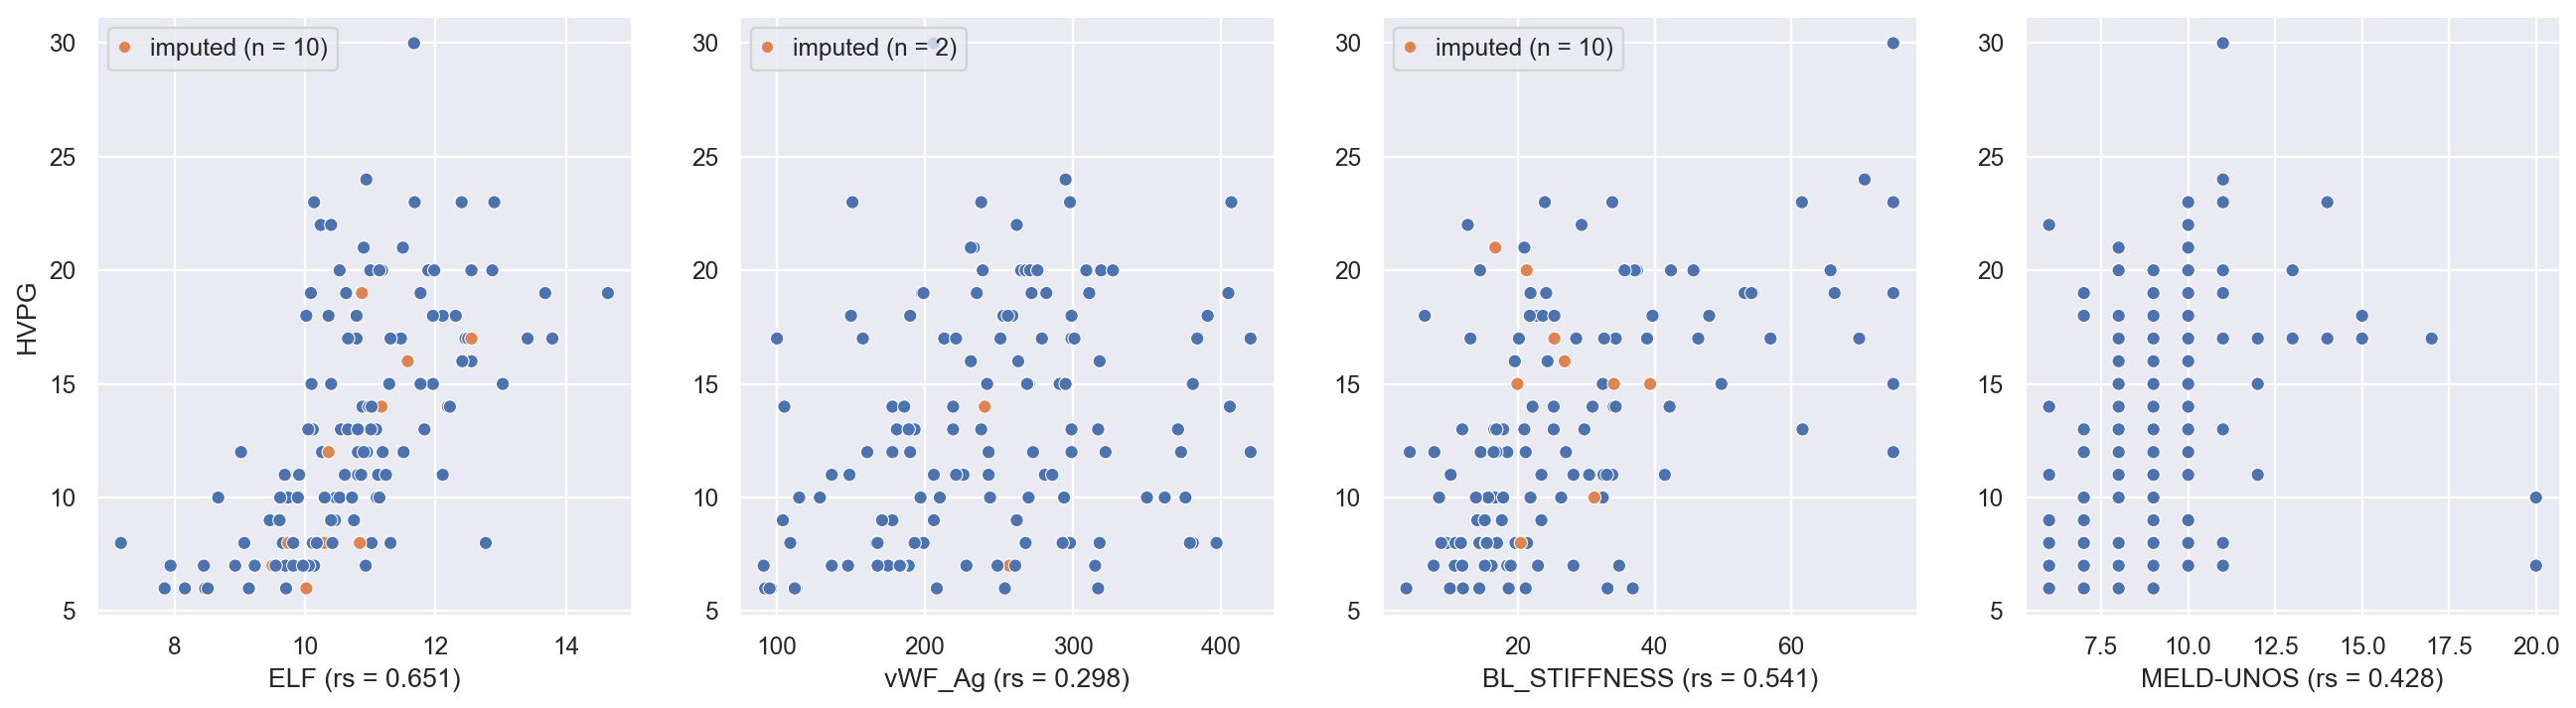

In [11]:
show_HVPG_scatter(merged, correlations, selected)

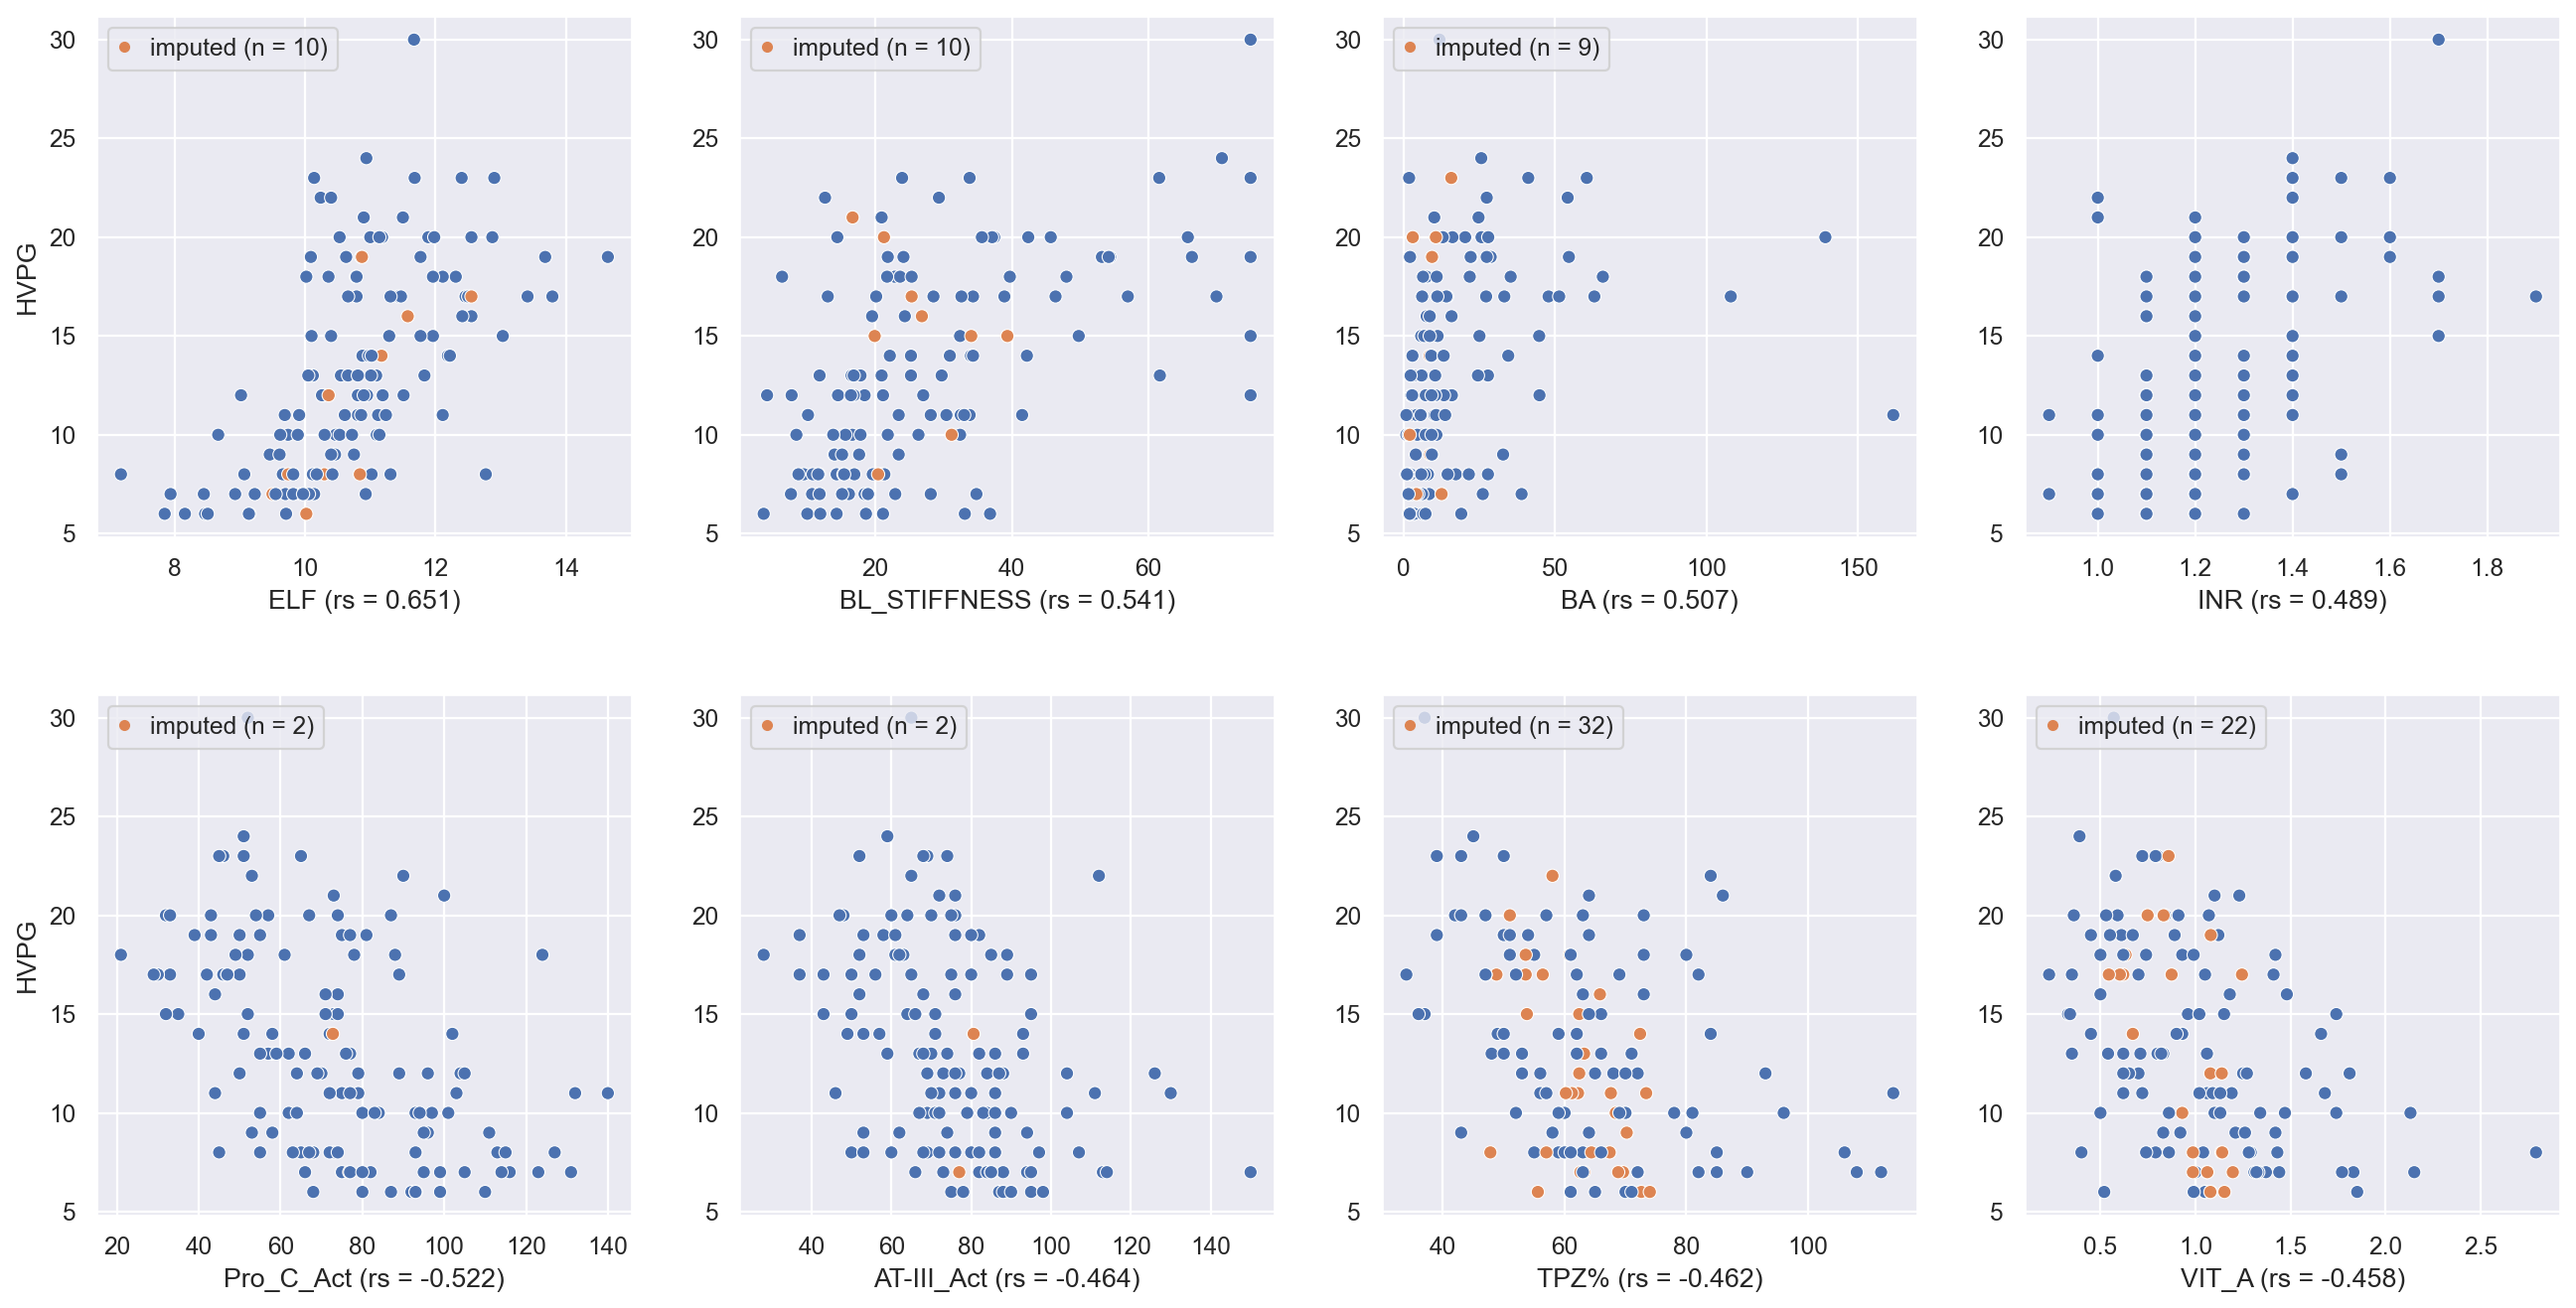

In [12]:
show_HVPG_scatter(merged, correlations, positive_corr+negative_corr)

## PCA

In [13]:
correlations.sort_values(ascending=True)[:25].index

Index(['Pro_C_Act', 'AT-III_Act', 'TPZ%', 'VIT_A', 'ALB', 'PLT', 'CHE', 'ERY',
       'Mg', 'HKT', 'KREA', 'HB', 'Ca', 'VIRAL', 'FGEN', 'BUN', 'LDL',
       'COPEPTIN-ADH', 'WBC', 'SEROTONIN', 'PT_F1,2', 'CHOL', 'LBP',
       'SFLT1/PLGF_Q', 'BA-TEST'],
      dtype='object', name='Variable')

In [ ]:
# separate predictor variables
X = data.iloc[:,6:]
X

In [ ]:
# initialize PCA
pca = PCA(n_components=3)

# take first three principal components
transformed = pd.DataFrame(pca.fit_transform(X), index=X.index, columns=["PC1", "PC2", "PC3"])

# add labels
transformed = pd.concat([data["HVPG_label"], transformed], axis=1)

# check how the data looks
transformed.sample(random_state = 42, n = 5)

[(-300.0, 600.0), (-400.0, 600.0)]

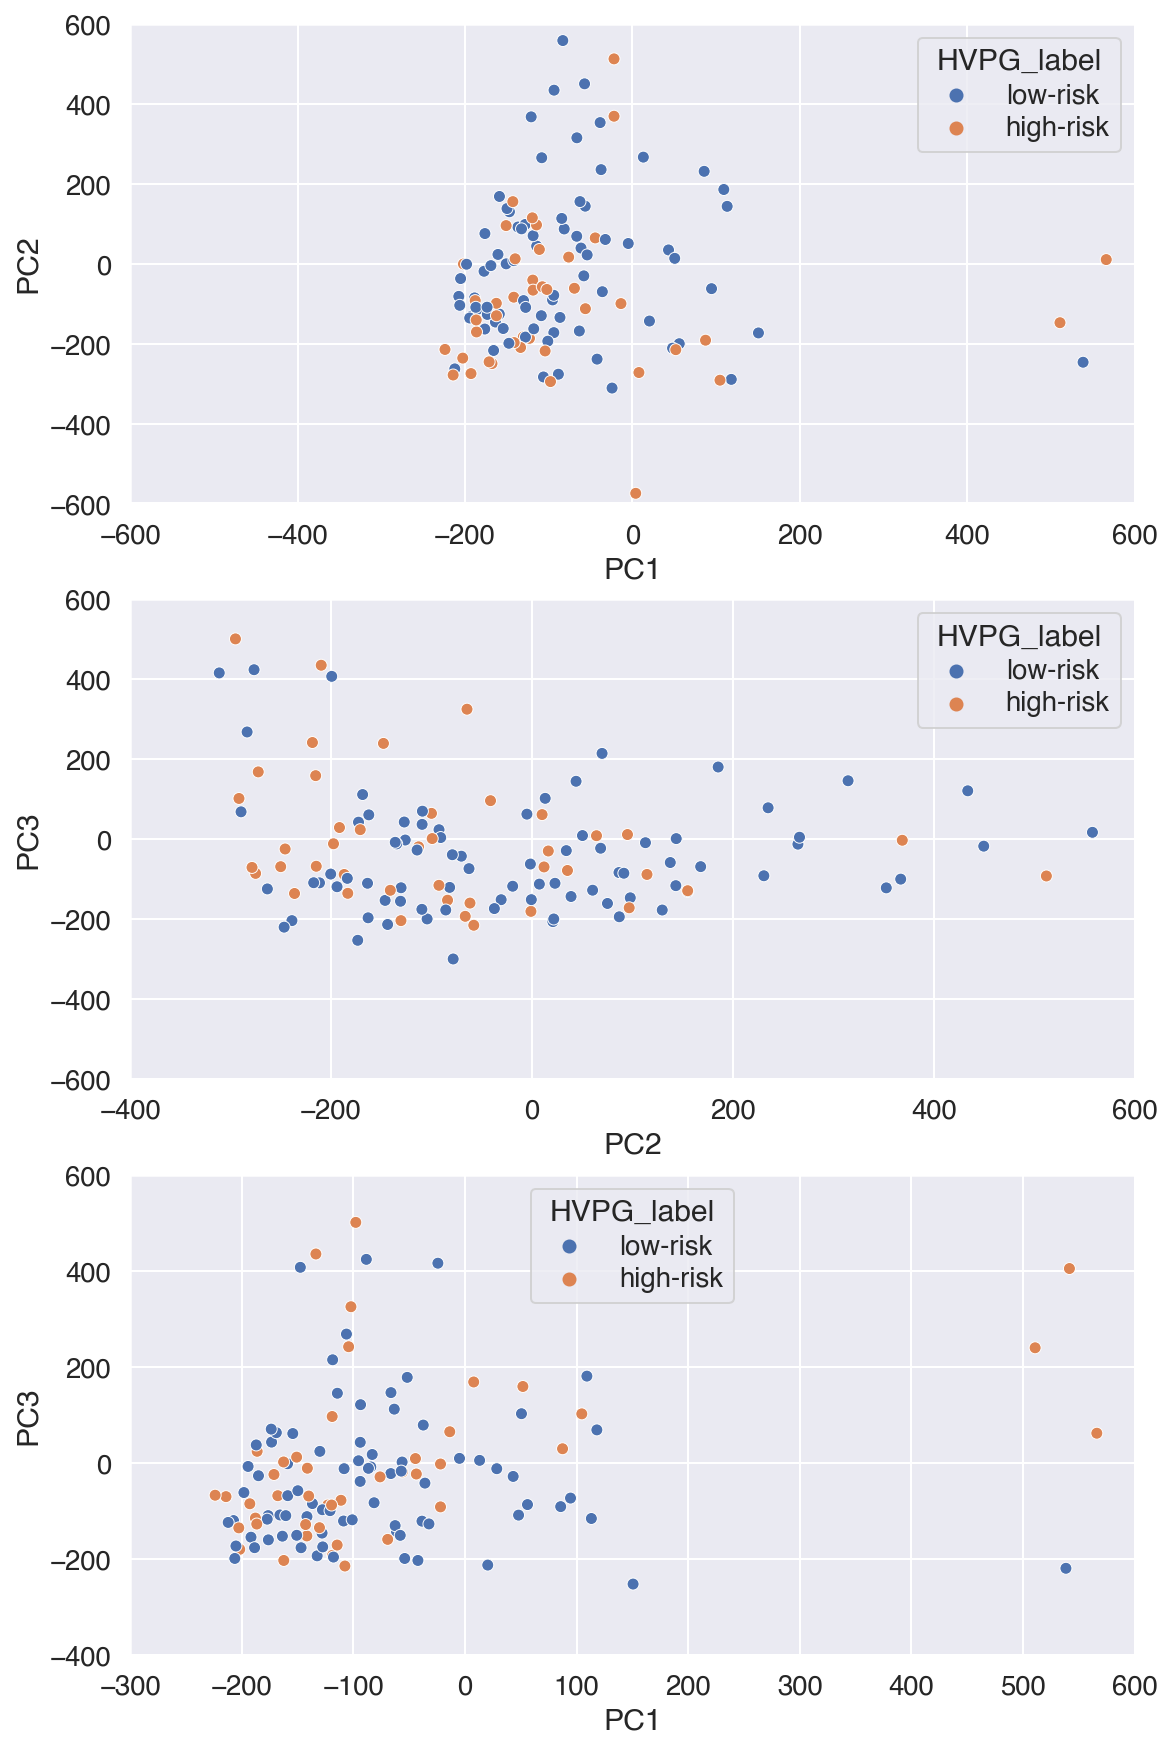

In [16]:
sns.set(font="Helvetica", font_scale=1.25)
fig, axes = plt.subplots(3, 1, figsize=(9, 15))

p1 = sns.scatterplot(data=transformed, x="PC1", y="PC2", hue="HVPG_label", ax = axes[0])
p1.set(xlim=(-600, 600), ylim=(-600, 600))

p2 = sns.scatterplot(data=transformed, x="PC2", y="PC3", hue="HVPG_label", ax = axes[1])
p2.set(xlim=(-400, 600), ylim=(-600, 600))

p3 = sns.scatterplot(data=transformed, x="PC1", y="PC3", hue="HVPG_label", ax = axes[2])
p3.set(xlim=(-300, 600), ylim=(-400, 600))


## Appendix: scatterplot of arbitrarily selected parameters against HVPG

In [17]:
params = ['PLT', 'BILI', 'CHE', 'GGT', 'aPTT', 'HISTAMINE', 'ELF']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

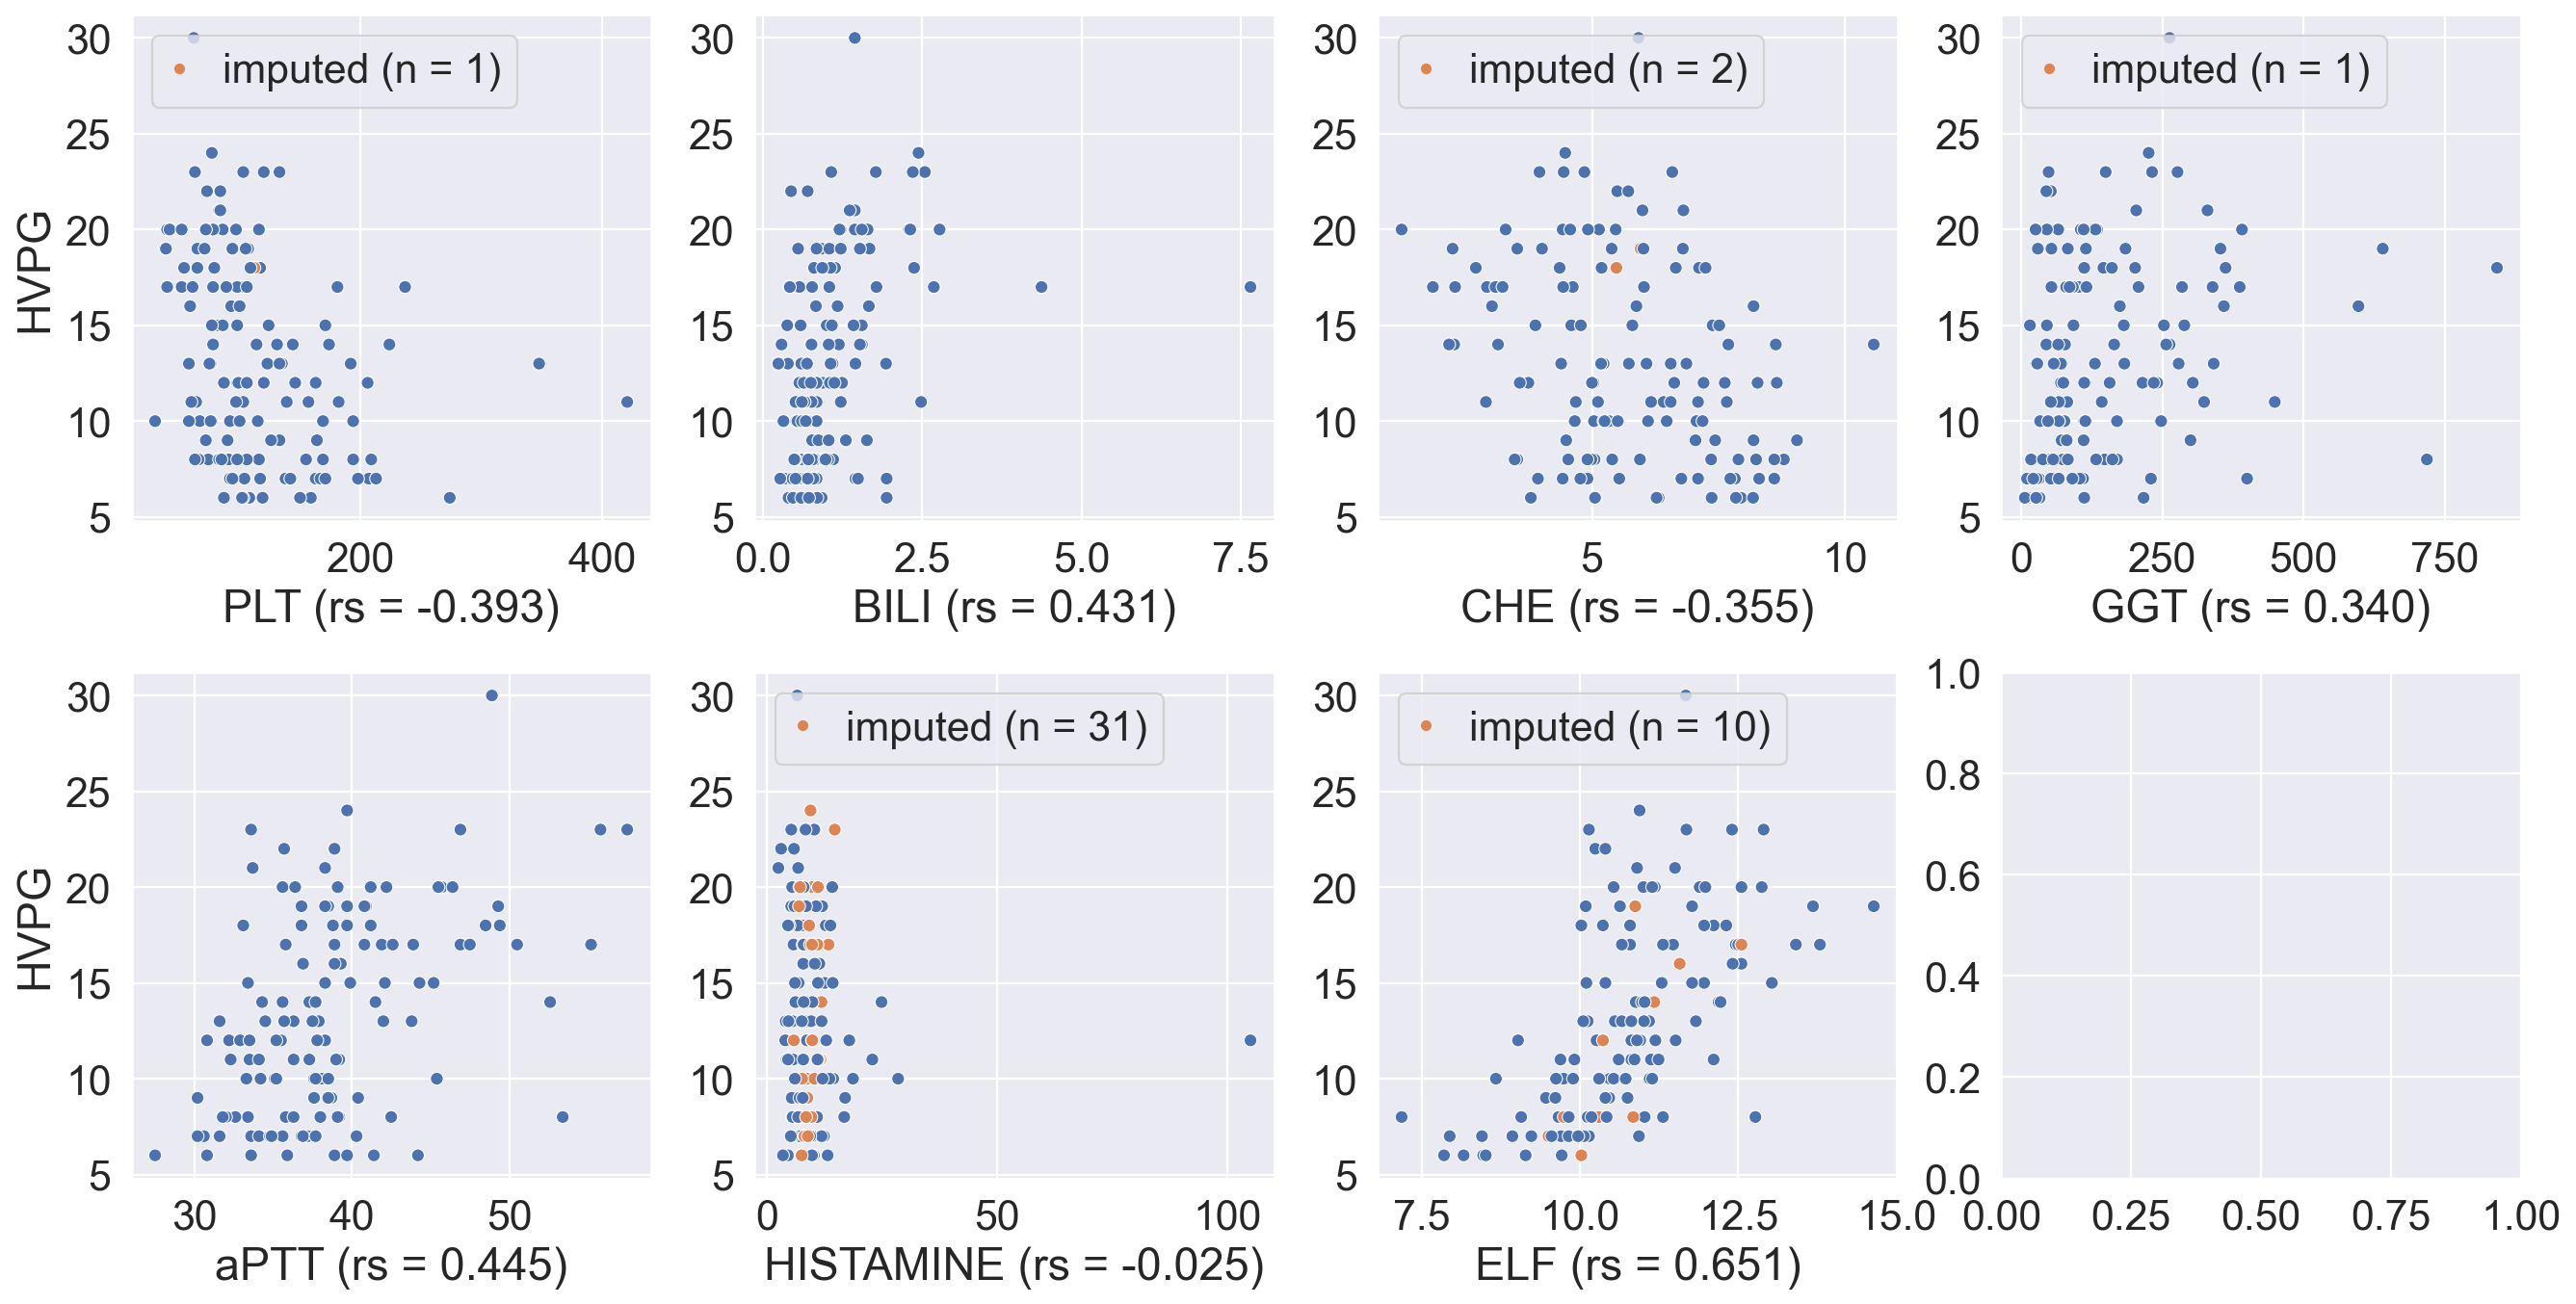

In [18]:
sns.set(font_scale=1.75)
show_HVPG_scatter(merged, correlations, params, save="/Users/jreinis/OneDrive/Rotation/rotation/report_latex/fig/scatterplot_bestvars.eps")